<a href="https://colab.research.google.com/github/diego-crai/IntroToDatabricksTechLab/blob/main/Databricks_PySpark_Example_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install pyspark

Scenario: Financial Data Analysis using PySpark
1. Environment Setup

Ensure PySpark is set up and running. Start a Spark session:

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Financial Data Analysis") \
    .getOrCreate()

2. Generating a Synthetic Financial Dataset

We'll create a DataFrame representing financial transactions with columns such as transaction_id, customer_id, amount, date, and category.

In [ ]:
from pyspark.sql.functions import rand, randn, to_date
import pyspark.sql.functions as F
from pyspark.sql import Row
import datetime

# Generate sample data
num_rows = 1000
data = (spark.range(num_rows)
        .withColumn("transaction_id", F.monotonically_increasing_id())
        .withColumn("customer_id", F.rand(seed=123) * 1000)
        .withColumn("amount", (F.randn(seed=456) * 200 + 1000).cast("decimal(10,2)"))
        .withColumn("date", to_date(F.expr("add_months(current_date(), -round(rand() * 12, 0))")))
        .withColumn("category", F.when((F.rand(seed=789) * 8).cast("int") < 3, "Groceries")
                                 .when((F.rand(seed=789) * 8).cast("int") == 4, "Electronics")
                                 .when((F.rand(seed=789) * 8).cast("int") == 5, "Clothing")
                                 .otherwise("Other"))
       )

data.show(5)

+---+--------------+------------------+-------+----------+---------+
| id|transaction_id|       customer_id| amount|      date| category|
+---+--------------+------------------+-------+----------+---------+
|  0|             0|157.95279750951363| 809.18|2023-07-18|    Other|
|  1|             1|  648.787283930924|1263.20|2023-04-18|Groceries|
|  2|             2| 952.9333503403406|1126.50|2023-04-18|    Other|
|  3|             3| 310.8354124889471|1042.36|2023-05-18| Clothing|
|  4|             4|182.36488937717797|1086.01|2023-09-18|Groceries|
+---+--------------+------------------+-------+----------+---------+
only showing top 5 rows



3. Data Preprocessing

Perform basic data cleaning and transformations as needed.

In [ ]:
# Example: Filtering out transactions with negative amounts
cleaned_data = data.filter(data.amount > 0)


4. Exploratory Data Analysis (EDA)

Conduct analysis to uncover insights from the data.

Summary Statistics: Understand the distribution of transaction amounts.

In [ ]:
cleaned_data.describe("amount").show()


+-------+------------------+
|summary|            amount|
+-------+------------------+
|  count|              1000|
|   mean|       1000.242610|
| stddev|196.02022282418704|
|    min|            432.10|
|    max|           1623.88|
+-------+------------------+



Trend Analysis: Analyze transaction trends over time.



In [ ]:
cleaned_data.groupBy(F.month("date")).agg(F.sum("amount")).show()



+-----------+-----------+
|month(date)|sum(amount)|
+-----------+-----------+
|         12|   90301.58|
|          1|   84267.63|
|          6|   85081.75|
|          3|   70632.85|
|          5|   95538.73|
|          9|   89473.44|
|          4|   94514.07|
|          8|   75239.25|
|          7|   83038.25|
|         10|   83264.30|
|         11|   66465.10|
|          2|   82425.66|
+-----------+-----------+



Category Analysis: Examine spending patterns across different categories.

In [ ]:
cleaned_data.groupBy("category").agg(F.avg("amount"), F.count("transaction_id")).show()


+-----------+-----------+---------------------+
|   category|avg(amount)|count(transaction_id)|
+-----------+-----------+---------------------+
|  Groceries|1008.937021|                  376|
|Electronics| 999.916316|                   76|
|   Clothing|1021.389722|                   72|
|      Other| 990.228130|                  476|
+-----------+-----------+---------------------+



5. Advanced Analysis

Perform more sophisticated analysis such as customer segmentation or anomaly detection (e.g., unusually large transactions).

In [ ]:
# Example: Finding top 10 customers by transaction amount
top_customers = cleaned_data.groupBy("customer_id").agg(F.sum("amount").alias("total_spent"))
top_customers.orderBy(F.desc("total_spent")).show(10)


+------------------+-----------+
|       customer_id|total_spent|
+------------------+-----------+
| 703.2367265125688|    1623.88|
|440.24237275435064|    1572.71|
| 525.7500192848876|    1562.29|
| 816.8958153901372|    1548.33|
| 751.7899936206534|    1535.60|
|116.14485968604794|    1500.63|
| 577.4601759132421|    1450.99|
|147.40706851704422|    1445.07|
| 520.6806637934492|    1427.79|
| 887.6883257790406|    1427.05|
+------------------+-----------+
only showing top 10 rows



Data Visualization in Google Colab
1. Convert PySpark DataFrame to Pandas DataFrame

Due to the limitations of PySpark in plotting directly, convert the DataFrame to a Pandas DataFrame. Keep in mind that this should be done with caution if the dataset is large, as it will collect the data to the local machine.

In [ ]:
pandas_df = cleaned_data.toPandas()


2. Import Visualization Libraries

Import Matplotlib and Seaborn for creating plots.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn style for better aesthetics
sns.set_style("whitegrid")


3. Creating Visualizations

a. Transaction Amount Distribution
Visualize the distribution of transaction amounts.

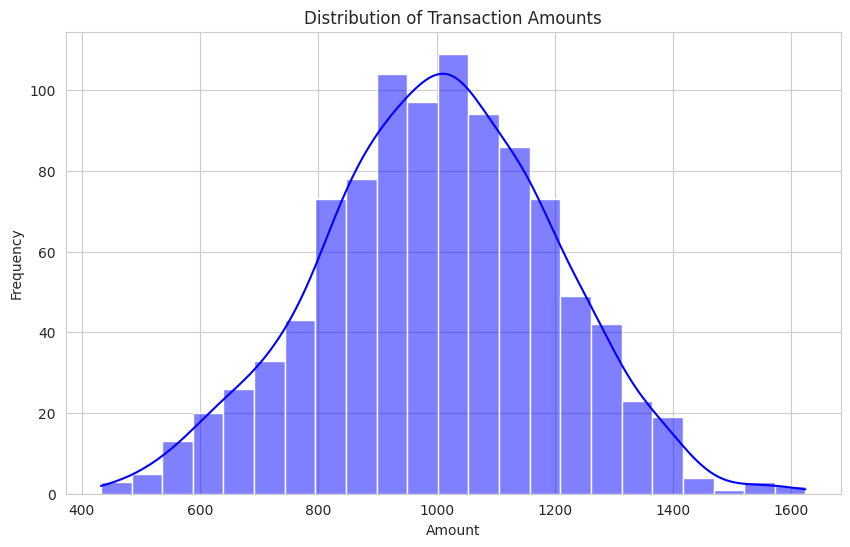

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['amount'], kde=True, color='blue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


b. Transactions Over Time

Plot the trend of transactions over time.

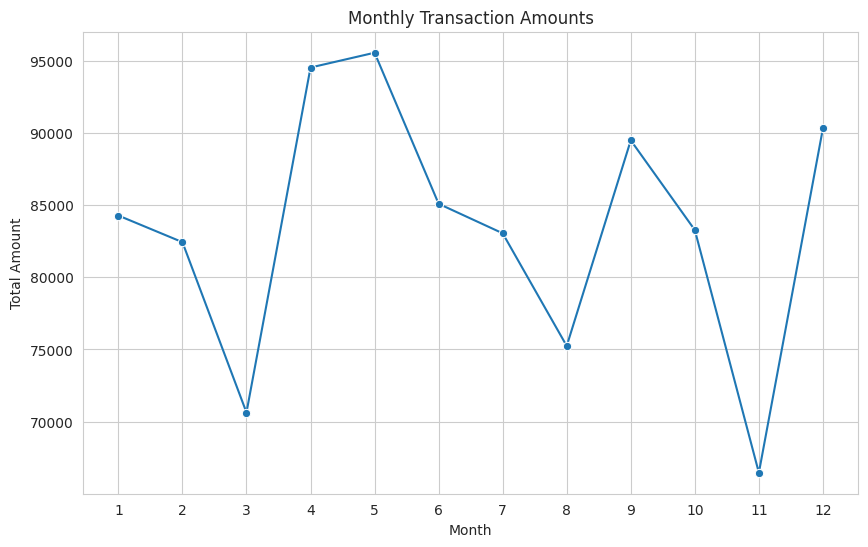

In [ ]:
import pandas as pd
pandas_df['date'] = pd.to_datetime(pandas_df['date'])
pandas_df['month'] = pandas_df['date'].dt.month
monthly_transactions = pandas_df.groupby('month')['amount'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_transactions, x='month', y='amount', marker='o')
plt.title('Monthly Transaction Amounts')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.xticks(range(1, 13))  # Months from 1 to 12
plt.show()


c. Spending Patterns by Category

Create a bar chart to show average spending in each category.

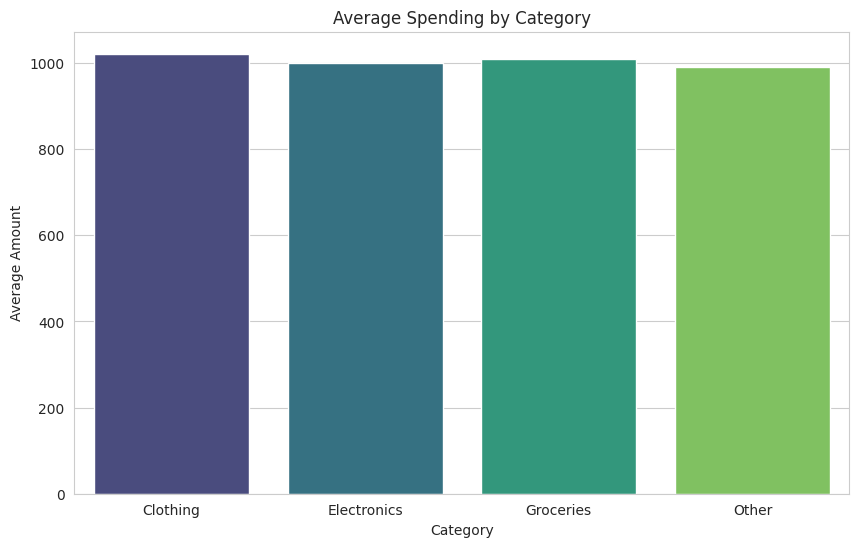

In [ ]:
category_analysis = pandas_df.groupby('category')['amount'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=category_analysis, x='category', y='amount', palette='viridis')
plt.title('Average Spending by Category')
plt.xlabel('Category')
plt.ylabel('Average Amount')
plt.show()
